In [ ]:
# install libraries we will use
!pip3 install ray pandas faker plotly altair vega

In [28]:
from urllib.parse import urlparse
from io import StringIO
from collections import Counter
from time import sleep
import random, logging
from itertools import combinations

import ray
import pandas as pd

## Let's index the internet!

In [2]:
#internet = requests.get('https://moz.com/top-500/download?table=top500Domains').text

In [3]:
df = pd.read_csv('internet.csv')
df

Rank       Root Domain Linking Root Domains  Domain Authority
0       1         apple.com            4,600,902               100
1       2       youtube.com           17,811,336               100
2       3    www.google.com           12,131,939               100
3       4   www.blogger.com           25,278,670                99
4       5   docs.google.com            2,273,261                99
..    ...               ...                  ...               ...
495   496  lonelyplanet.com              152,050                92
496   497  entrepreneur.com              220,299                92
497   498           inc.com              208,880                92
498   499           fda.gov              281,189                92
499   500         upenn.edu              264,002                92

[500 rows x 4 columns]

In [7]:
ray.init(ignore_reinit_error=True, logging_level=logging.CRITICAL)

In [8]:
@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures))

[0, 1, 4, 9]


In [9]:
@ray.remote
def index(url):
    print(f"I'm Sleeping on {url}")
    sleep(.5)
    print(f"I'm Awake, time to get {url}")
    return url.split('.')[-1]

futures = [index.remote(site) for site in df['Root Domain'].to_list()[:30]]
Counter(ray.get(futures))

(pid=89657) I'm Sleeping on microsoft.com
(pid=89658) I'm Sleeping on youtube.com
(pid=89662) I'm Sleeping on www.blogger.com
(pid=89659) I'm Sleeping on apple.com
(pid=89664) I'm Sleeping on en.wikipedia.org
(pid=89660) I'm Sleeping on linkedin.com
(pid=89661) I'm Sleeping on cloudflare.com
(pid=89665) I'm Sleeping on wordpress.org
(pid=89668) I'm Sleeping on docs.google.com
(pid=89666) I'm Sleeping on play.google.com
(pid=89667) I'm Sleeping on www.google.com
(pid=89686) I'm Sleeping on support.google.com
(pid=89657) I'm Awake, time to get microsoft.com
(pid=89657) I'm Sleeping on vimeo.com
(pid=89658) I'm Awake, time to get youtube.com
(pid=89658) I'm Sleeping on googleusercontent.com
(pid=89662) I'm Awake, time to get www.blogger.com
(pid=89662) I'm Sleeping on medium.com
(pid=89659) I'm Awake, time to get apple.com
(pid=89659) I'm Sleeping on maps.google.com
(pid=89664) I'm Awake, time to get en.wikipedia.org
(pid=89664) I'm Sleeping on plus.google.com
(pid=89660) I'm Awake, time 

Counter({'com': 23, 'org': 4, 'eu': 1, 'be': 1, 'uk': 1})

(pid=89657) I'm Awake, time to get creativecommons.org
(pid=89658) I'm Awake, time to get bbc.co.uk
(pid=89659) I'm Awake, time to get istockphoto.com
(pid=89661) I'm Awake, time to get vk.com
(pid=89666) I'm Awake, time to get bp.blogspot.com
(pid=89686) I'm Awake, time to get facebook.com


## Dashboard

![](images/ray-dash.gif)

## Introducing Actors (stateful tasks)

Scheme made them [concrete](https://dspace.mit.edu/handle/1721.1/5794). Erlang made them [useful](https://erlang.org/doc/getting_started/conc_prog.html). Akka made them [cool](https://akka.io/). And now Ray makes them [easy](https://docs.ray.io/en/latest/ray-overview/index.html)!

In [10]:
@ray.remote
class Child(object):
    def __init__(self):
        from faker import Faker
        self.name = Faker().name()
        self.age = 1

    def grow(self):
        self.age += 1
        return self.age

    def greet(self):
        return (
            f'My name is {self.name} '
            f'and I am {self.age} years old'
        )

In [11]:
children = [Child.remote() for i in range(10)]

for c in children:
    for _ in range(random.randint(1, 10)):
        c.grow.remote()
        
futures = [c.greet.remote() for c in children]

for future in ray.get(futures):
    print(future)

My name is Sean Patterson and I am 2 years old
My name is Vanessa Crawford and I am 8 years old
My name is Gregory Sandoval and I am 4 years old
My name is William Lopez and I am 5 years old
My name is Andrea Leon and I am 9 years old
My name is Taylor Zimmerman and I am 9 years old
My name is Brianna Daniel and I am 6 years old
My name is Deanna Moyer and I am 5 years old
My name is Taylor Shelton and I am 5 years old
My name is Victoria Espinoza and I am 7 years old


In [12]:
c = children[0]

In [13]:
print(ray.get([c.grow.remote() for _ in range(5)]))

[3, 4, 5, 6, 7]


In [14]:
# actors stay around as long as they are in scope
# since nothing really goes out of scope in a notebook
# we have to manually terminate them
[ ray.kill(person) for person in children ]

[None, None, None, None, None, None, None, None, None, None]

In [15]:
# or just shutdown ray
ray.shutdown()

## Simulating a pandemic

> note this is a toy model simulation, results should not be used to inform health decisions or personal behavior

### The SIR epidemic model:

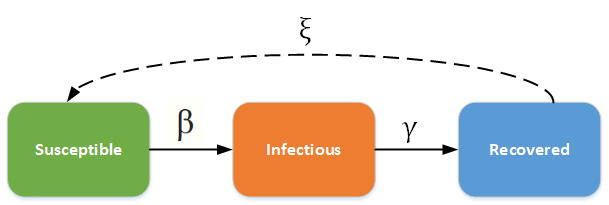

$S(t)$: susceptible individuals who have not yet been infected at time $t$

$I(t)$: number of infections individuals at time $t$

$R(t)$: number of individuals who have recovered (and are immune) at time $t$

#### Parameters

$\beta$: probablity of transmitted the disease from an infected to a susceptible individual

$\gamma$: recovery rate ~ $\frac{1}{\text{duration of disease}}$

We will follow the [EMOD compartamental model](https://idmod.org/docs/emod/malaria/model-compartments.html) to simulate the SIR model as a series of discrete timesteps. For something like reinforcement learning, instead of disease dynamics you simulate actions in an environment/game.

In [16]:
ray.init(ignore_reinit_error=True, logging_level=logging.ERROR)

# parameters
b = 0.5
b_0 = 0.2
g = 0.2

In [17]:
@ray.remote
class Person(object):
    def __init__(self, i):
        self.index = i
        self.state = 'i' if random.random() < b_0 else 's'
        self.x = random.randint(0, 10)
        self.y = random.randint(0, 10)

    def location(self):
        return (self.x, self.y)
    
    def health(self):
        return self.state
    
    def index(self):
        return self.index
    
    def status(self):
        return f"Individual {self.index} at {self.location()} is currently {self.state}"
        
    # Just getters/setters above 👆
    
    # Actual methods below 👇
    def walk(self):
        if self.state == 'i':
            if random.random() < g:
                print(f"Individual {self.index} has recovered 🤗")
                self.state = 'r'
                
        self.x += random.randint(-1, 1)
        self.x += random.randint(-1, 1)
        
        self.x = max(min(self.x, 10), 0)
        self.y = max(min(self.y, 10), 0)
        
    def contract(self):
        print(f"{self.index} has become sick 🤮")
        self.state = 'i'
    
    def interact(self, stranger):
        x, y = ray.get(stranger.location.remote())
        state = ray.get(stranger.health.remote())
        
        # is the stranger close to me
        if (abs(x - self.x) <= 1) and (abs(y - self.y) <= 1):
            # is either of us infected?
            if self.state == 'i' or state == 'i':
                # can either of us _get_ infected?
                if self.state == 's' or state == 's':
                    # which one of us can get the disease
                    target = self.contract if self.state == 's' else stranger.contract.remote
                    
                    # roll the dice babeeeeee
                    if random.random() < b:
                        target()                

In [19]:
people = [Person.remote(i) for i in range(10)]

In [20]:
person = people[0]

In [21]:
ray.get(person.location.remote())

(0, 3)

In [22]:
ray.get([p.location.remote() for p in people])

[(0, 3),
 (5, 3),
 (10, 10),
 (5, 2),
 (5, 1),
 (4, 0),
 (8, 8),
 (1, 5),
 (4, 1),
 (6, 3)]

In [24]:
ray.get([p.health.remote() for p in people])

['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']

In [25]:
for person in people:
    ray.kill(person)

In [26]:
ray.get([p.health.remote() for p in people])

RayActorError: The actor died unexpectedly before finishing this task.

In [27]:
people = [Person.remote(i) for i in range(10)]

In [29]:
for person1, person2 in combinations(people, 2):
    person1.interact.remote(person2)

In [30]:
ray.shutdown()
ray.init(ignore_reinit_error=True, logging_level=logging.ERROR)

{'node_ip_address': '192.168.1.107',
 'raylet_ip_address': '192.168.1.107',
 'redis_address': '192.168.1.107:6379',
 'object_store_address': '/tmp/ray/session_2020-09-01_00-30-25_928479_89641/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-09-01_00-30-25_928479_89641/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-09-01_00-30-25_928479_89641'}

## Putting it all together

In [31]:
n = 50

progress = {
    's': [],
    'i': [],
    'r': []
}

people = [Person.remote(i) for i in range(n)]

for i in range(20):
    print(f"\nIteration {i}\n\n")
    for k in progress:
        progress[k].append(0)
        
    for person in people:
        person.walk.remote()
        
    # everybody's mingling....
    pairs = list(combinations(people, 2))
            
    for p1, p2 in pairs:
        p1.interact.remote(p2)
        
    for p in people:
        progress[ray.get(p.health.remote())][-1] += 1


Iteration 0


(pid=89808) Individual 3 has recovered 🤗
(pid=89859) Individual 35 has recovered 🤗
(pid=89872) 36 has become sick 🤮
(pid=89874) 37 has become sick 🤮
(pid=89854) 33 has become sick 🤮
(pid=89856) 31 has become sick 🤮
(pid=89850) 27 has become sick 🤮
(pid=89831) 18 has become sick 🤮
(pid=89885) 42 has become sick 🤮
(pid=89824) 15 has become sick 🤮
(pid=89805) 9 has become sick 🤮
(pid=89804) 7 has become sick 🤮
(pid=89801) 5 has become sick 🤮
(pid=89857) 30 has become sick 🤮
(pid=89800) 2 has become sick 🤮

Iteration 1


(pid=89850) Individual 27 has recovered 🤗
(pid=89855) Individual 32 has recovered 🤗
(pid=89885) Individual 42 has recovered 🤗
(pid=89892) Individual 47 has recovered 🤗
(pid=89897) 49 has become sick 🤮
(pid=89827) 13 has become sick 🤮
(pid=89848) 24 has become sick 🤮
(pid=89832) 21 has become sick 🤮
(pid=89849) 25 has become sick 🤮
(pid=89870) 34 has become sick 🤮

Iteration 2


(pid=89870) Individual 34 has recovered 🤗
(pid=89872) Individual 36 has recovered

In [33]:
df = pd.DataFrame(progress).reset_index()
melted = pd.melt(df, id_vars=['index'], value_vars=['s', 'i', 'r'])
melted.columns = ['index', 'variable', 'percent']
melted.loc[melted.variable == "s", "status"] = 'Susceptible'
melted.loc[melted.variable == "i", "status"] = 'Infected'
melted.loc[melted.variable == "r", "status"] = 'Recovered'
melted['percent'] = melted.percent / n
melted.head()

index variable  percent       status
0      0        s     0.58  Susceptible
1      1        s     0.46  Susceptible
2      2        s     0.44  Susceptible
3      3        s     0.36  Susceptible
4      4        s     0.36  Susceptible

In [34]:
for person in people:
    print(ray.get(person.status.remote()))

Individual 0 at (2, 10) is currently s
Individual 1 at (8, 4) is currently s
Individual 2 at (4, 5) is currently r
Individual 3 at (6, 10) is currently r
Individual 4 at (6, 6) is currently r
Individual 5 at (6, 5) is currently r
Individual 6 at (7, 10) is currently s
Individual 7 at (3, 6) is currently r
Individual 8 at (10, 7) is currently r
Individual 9 at (3, 6) is currently r
Individual 10 at (3, 1) is currently s
Individual 11 at (8, 4) is currently s
Individual 12 at (2, 4) is currently r
Individual 13 at (8, 4) is currently r
Individual 14 at (9, 10) is currently s
Individual 15 at (1, 6) is currently r
Individual 16 at (6, 10) is currently r
Individual 17 at (1, 6) is currently r
Individual 18 at (2, 5) is currently r
Individual 19 at (1, 0) is currently s
Individual 20 at (3, 0) is currently s
Individual 21 at (3, 10) is currently r
Individual 22 at (10, 0) is currently s
Individual 23 at (9, 0) is currently s
Individual 24 at (1, 3) is currently r
Individual 25 at (3, 7) is 

In [35]:
import altair as alt

In [36]:
alt.Chart(melted, width=800).mark_area().encode(
        alt.X(
            "index", 
            scale=alt.Scale(domain=(0, 19)),
            axis=alt.Axis(title="t")
            ), 
        alt.Y(
            "percent", 
            stack="normalize",
            axis=alt.Axis(
                title=" ",
                format="%"
            )
        ),
        color=alt.Color('status', 
                        legend=alt.Legend(title="Individuals"), 
                        scale=alt.Scale(
                            domain=['Infected', 'Recovered', "Susceptible"],
                            range=['rgb(242, 34, 255)', 'rgb(144, 244, 148)', 'rgb(167, 184, 227)']
                            )
                       ),
        tooltip=['percent', 'status']
).interactive()

alt.Chart(...)